In [2]:
from dotenv import load_dotenv
import os

load_dotenv(verbose=True)
key = os.getenv('OPENAI_API_KEY')

In [3]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

from rag.pdf import PDFRetrievalChain
from langchain_teddynote.tools.tavily import TavilySearch

from typing import List, Literal
from typing_extensions import TypedDict, Annotated
from pydantic import BaseModel, Field
from langchain_core.documents import Document

In [4]:
class GraphState(TypedDict):
    """
    그래프의 상태를 나타내는 데이터 모델

    Attributes:
        question: 질문
        generation: LLM 생성된 답변
        documents: 도큐먼트 리스트
    """

    question: Annotated[str, "User question"]
    generation: Annotated[str, "LLM generated answer"]
    documents: Annotated[List[str], "List of documents"]

### PDF 기반 문서 검색기 (Retrieval chain) 생성

In [5]:
from rag.pdf import PDFRetrievalChain

# PDF 문서를 로드
pdf = PDFRetrievalChain(['data/SPRI_AI_Brief_2023년12월호_F.pdf']).create_chain()

pdf_retriever = pdf.retriever       # retriever 생성
pdf_chain = pdf.chain               # pdf retriever chain 생성

### PDF 기반 문서 검색기 (Retrieval chain) : 사용자 질문에 대한 PDF 문서를 검색

In [6]:
# 문서 검색 노드
def retrieve(state: GraphState):
    print('\n==========================================================================================')
    print('===== [RETRIEVE] retieve() 노드 실행 =====')

    # 사용자 질문
    question = state['question']        

    # 문서 검색 (pdf_retriever 에 사용자 입력을 인자로 넣어서 문서를 검색)
    documents = pdf_retriever.invoke(question)
    
    print(f'문서 검색 결과: ')
    print(documents)
    print('==========================================================================================\n')
    
    return {'documents': documents}

### 답변 생성을 위한 RAG 체인

In [7]:
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI
from langchain import hub

# prompt = hub.pull("teddynote/rag-prompt")

template = """You are an AI assistant specializing in Question-Answering (QA) tasks within a Retrieval-Augmented Generation (RAG) system. 
Your primary mission is to answer questions based on provided context or chat history.
Ensure your response is concise and directly addresses the question without any additional narration.

###

Your final answer should be written concisely (but include important numerical values, technical terms, jargon, and names), followed by the source of the information.

# Steps

1. Carefully read and understand the context provided.
2. Identify the key information related to the question within the context.
3. Formulate a concise answer based on the relevant information.
4. Ensure your final answer directly addresses the question.
5. List the source of the answer in bullet points, which must be a file name (with a page number) or URL from the context. Omit if the source cannot be found.

# Output Format:
[Your final answer here, with numerical values, technical terms, jargon, and names in their original language]

**Source**(Optional)
- (Source of the answer, must be a file name(with a page number) or URL from the context. Omit if you can't find the source of the answer.)
- (list more if there are multiple sources)
- ...

###

Remember:
- It's crucial to base your answer solely on the **PROVIDED CONTEXT**. 
- DO NOT use any external knowledge or information not present in the given materials.
- If you can't find the source of the answer, you should answer that you don't know.

###

# Here is the user's QUESTION that you should answer:
{question}

# Here is the CONTEXT that you should use to answer the question:
{context}

# Your final ANSWER to the user's QUESTION:"""

prompt = ChatPromptTemplate.from_template(template)

llm = ChatOpenAI(
    api_key=key, 
    model='gpt-4o-mini', 
    temperature=0
)

def format_docs(docs):
    return "\n\n".join(
        [
            f'<document><content>{doc.page_content}</content><source>{doc.metadata["source"]}</source><page>{doc.metadata["page"]+1}</page></document>'
            for doc in docs
        ]
    )

output_parser = StrOutputParser()

# RAG 체인 생성 (pdf_retriever 문서 검색기를 사용해서 얻은 문서와 사용자 질문을 넣어서 결과)
rag_chain = prompt | llm | output_parser

### 답변 생성을 위한 RAG 체인을 실행하여 사용자 질문에 대한 답변을 생성하는 노드

In [8]:
# 답변 생성 노드
def generate(state: GraphState):
    print('\n==========================================================================================')
    print('===== [GENERATE] generate() 함수 =====')

    # 사용자 질문
    question = state['question']  

    # 문서 검색 결과
    documents = state['documents']

    # RAG 실행 결과
    generation = rag_chain.invoke({'context': documents , 'question': 'question'})

    print(f'사용자 질문: {question}')
    print(f'문서 검색 결과:')
    print(documents)
    print()
    print(f'rag 실행 결과:')
    print(generation)
    print()
    print('==========================================================================================\n')    

    return {'generation': generation}

### 문서 검색 평가기 (Retrieval Grader)

In [9]:
class GradeDocuments(BaseModel):        # 문서 평가를 위한 데이터 모델
    """Binary score for relevance check on retrieved documents."""

    # 사용자 질문에 대한 pdf 문서 검색 결과를 평가하는 문서 검색 평가기(retrieval_grader)를 사용해서 
    # 사용자 질문과 검색 결과문서가 관련성이 있는지 본다

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )

llm = ChatOpenAI(
    api_key=key, 
    model='gpt-4o-mini', 
    temperature=0
)

structured_llm_grader = llm.with_structured_output(GradeDocuments)

# 시스템 메시지
system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""

# 프롬프트 템플릿
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

# 문서 검색결과 평가기
retrieval_grader = grade_prompt | structured_llm_grader

### 사용자 질문에 대한 pdf 문서 검색 결과의 관련성을 평가하는 문서 검색 평가기(retrieval_grader) 노드

In [10]:
# 문서 검색 결과와 질문 관련성 평가 노드
def grade_documents(state: GraphState):
    print('\n==========================================================================================')
    print('===== [CHECK DOCUMENT RELEVANCE TO QUESTION] grade_documents() 함수 =====')

    # 사용자 질문
    question = state['question']  

    # 문서 검색 결과
    documents = state['documents']

    # 문서 검색 평가기를 통과한 문서들만 필터링
    filtered_docs = []

    for doc in documents:
        score = retrieval_grader.invoke({'question': question, 'document': doc.page_content})

        grade = score.binary_score

        if grade == 'yes':
            print("---GRADE: DOCUMENT RELEVANT---")     
            filtered_docs.append(doc)                   
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---") 
            continue     

    print('==========================================================================================\n')
    return {'documents': filtered_docs}

### 쿼리 재작성 (Query Rewriter)

In [11]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser


llm = ChatOpenAI(
    api_key=key, 
    model='gpt-4o-mini', 
    temperature=0
)

# Query Rewriter 프롬프트
system = """You a question re-writer that converts an input question to a better version that is optimized \n 
for vectorstore retrieval. Look at the input and try to reason about the underlying semantic intent / meaning."""

re_writer_prompt = ChatPromptTemplate.from_messages(
    [
        ('system', system), 
        ('human', 'Here is the initial question: \n\n {question} \n Formulate an improved question')
    ]
)

# Query Rewriter 생성
question_rewriter = re_writer_prompt | llm | StrOutputParser()

### Query Rewrite 노드

In [12]:
# Query Rewrite 노드
def transform_query(state: GraphState):
    print('\n==========================================================================================')
    print('===== [TRANSFORM QUERY] transform_query() 함수 =====')

    # 사용자 질문
    question = state['question']

    # 문서 검색 결과
    documents = state['documents']

    
    # 쿼리 재작성
    better_question = question_rewriter.invoke({'question': question})
    print(f"better_question: {better_question}")
    print('==========================================================================================\n')

    return {'question': better_question}

### 웹 검색 도구

In [13]:
from langchain_teddynote.tools.tavily import TavilySearch

# 웹 검색 도구 생성
web_search_tool = TavilySearch(max_results=2)

### 웹 검색 노드

In [14]:
# 웹 검색 노드
def web_search(state):
    print('\n==========================================================================================')
    print('===== [WEB SEARCH] web_search() 함수 =====')

    # 사용자 질문
    question = state['question']
    
    print(f"question: ")
    print(question)
    print()

    # 웹 검색 수행
    web_results = web_search_tool.invoke({"query": question})

    print('web_results: ')
    print(web_results)
    print()

    web_results_docs = []
    
    for result in web_results:
        doc = Document(
            page_content=result["content"],
            metadata={"source": result["url"]}
        )
        web_results_docs.append(doc)

    print(web_results_docs)
    print('==========================================================================================\n')

    return {"documents": web_results_docs}

### 질문 라우팅 노드

In [15]:
class RouteQuery(BaseModel):    
    """Route a user query to the most relevant datasource."""

    datasource: Literal["vectorstore", "web_search"] = Field(
        ...,
        description="Given a user question choose to route it to web search or a vectorstore.",
    )


llm = ChatOpenAI(
    api_key=key, 
    model='gpt-4o-mini', 
    temperature=0
)

# 구조화된 출력을 결과로 가젼온다 (vectorstore, web_search)
structured_llm_router = llm.with_structured_output(RouteQuery)

# 시스템 메시지
system = """You are an expert at routing a user question to a vectorstore or web search.
The vectorstore contains documents related to DEC 2023 AI Brief Report(SPRI) with Samsung Gause, Anthropic, etc.
Use the vectorstore for questions on these topics. Otherwise, use web-search."""

# 프롬프트
route_prompt = ChatPromptTemplate.from_messages(
    [
        ('system', system), 
        ('human', '{question}')
    ]
)

question_router = route_prompt | structured_llm_router

### 질문 라우팅 노드

In [16]:
# 질문 라우팅 노드
def route_question(state: GraphState):
    print('\n==========================================================================================')
    print('===== [ROUTE QUESTION] route_question() 함수 =====')

    # 사용자 질문
    question = state['question']

    # 질문 라우팅
    source = question_router.invoke({'question': question})

    if source.datasource == "web_search":
        print("==== [ROUTE QUESTION TO WEB SEARCH] ====")
        print('==========================================================================================\n')
        return "web_search"
    elif source.datasource == "vectorstore":
        print("==== [ROUTE QUESTION TO VECTORSTORE] ====")
        print('==========================================================================================\n')
        return "vectorstore"

### 문서 관련성 평가 노드

In [17]:
# 문서 관련성 평가 노드
def decide_to_generate(state: GraphState):
    print('\n==========================================================================================')
    print('===== [DECISION TO GENERATE] decide_to_generate() 함수 =====')

    # 문서 검색 결과 가져오기
    filtered_documents = state['documents']

    if not filtered_documents:                              # 문서가 없는 경우 (모든 문서가 관련성 없는 문서)
        print(f'===== [DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY] =====')
        print('==========================================================================================\n')
        return "transform_query"        
    else:                                                   # 관련성 있는 문서가 있는 경우
        print(f"===== [DECISION: GENERATE] =====")
        print('==========================================================================================\n')
        return "generate"

# 답변에 대한 Hallucination checker 추가

In [18]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )


llm = ChatOpenAI(
    api_key=key, 
    model='gpt-4o-mini', 
    temperature=0
)

structured_hallucination_grader = llm.with_structured_output(GradeHallucinations)

# system
system = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n 
    Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts."""

# 프롬프트
hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
) 

# hallucination 평가기 생성
hallucination_grader = hallucination_prompt | structured_hallucination_grader

In [19]:
class GradeAnswer(BaseModel):
    """Binary scoring to evaluate the appropriateness of answers to questions"""

    binary_score: str = Field(
        description="Indicate 'yes' or 'no' whether the answer solves the question"
    )

llm = ChatOpenAI(
    api_key=key, 
    model='gpt-4o-mini', 
    temperature=0
)

structured_llm_grader = llm.with_structured_output(GradeAnswer)

# system
system = """You are a grader assessing whether an answer addresses / resolves a question \n 
     Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""

# 프롬프트 템플릿
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

# 프롬프트 템플릿과 구조화된 LLM 평가기를 결합하여 답변 평가기 생성
answer_grader = answer_prompt | structured_llm_grader

### hallucination_check

In [20]:
# Hallucination 평가 노드
def hallucination_check(state: GraphState):
    print('\n==========================================================================================')
    print('===== [CHECK hallucination] hallucination_check() 함수 =====')

    # 사용자 질문
    qestion = state['question']

    # 문서 검색 결과
    documents = state['documents']

    # 생성된 답변
    generation = state['generation']

    # 평가
    score = hallucination_grader.invoke({'documents': documents, 'generation': generation})
    grade = score.binary_score

    print(f"===== [평가 결과] =====")
    print(grade)

    if grade == 'yes':     # hallucination 없음
        print("===== [DECISION: GENERATION IS GROUNDED IN DOCUMENTS] =====")
        print("no hallucination")

        # 답변에 대한 관련성 평가
        print("===== [GRADE GENERATED ANSWER vs QUESTION] =====")

        score = answer_grader.invoke({'question': state['question'], 'generation': generation})
        grade = score.binary_score

        if grade == 'yes':          # 관련성 있는 답변
            print("==== [DECISION: GENERATED ANSWER ADDRESSES QUESTION] ====")
            print("relevant")
            print('==========================================================================================\n')
            return "relevant"
        else:                       # 관련성 없는 답변
            print("==== [DECISION: GENERATED ANSWER DOES NOT ADDRESS QUESTION] ====")
            print("not relevant")
            print('==========================================================================================\n')
            return "not relevant"

    else:                   # hallucination 있음
        print("===== [DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY] =====")
        print("hallucination")
        print('==========================================================================================\n')
        return "hallucination"

# 테스트

In [21]:
state = GraphState(
    question='대구 중앙떡볶이',
    generation = '', 
    documents = []
)

state

{'question': '대구 중앙떡볶이', 'generation': '', 'documents': []}

In [22]:
route_question(state)


===== [ROUTE QUESTION] route_question() 함수 =====
==== [ROUTE QUESTION TO WEB SEARCH] ====



'web_search'

In [23]:
web_search(state)


===== [WEB SEARCH] web_search() 함수 =====
question: 
대구 중앙떡볶이

web_results: 
[{'title': '대구 맛집 백종원 3대 천왕 :: 중앙떡볶이 솔직 후기 : 네이버 블로그', 'url': 'https://m.blog.naver.com/ryu8145/223424913321', 'content': '대구 떡볶이 맛집 중앙떡볶이. 포장도 많이 해가시던데 떡볶이 국물을 따뜻한 밥위에. 부은 후 전자렌지 돌려 먹어도. 넘 맛있다고 합니다 그럼 지금까지 대구 동성로. 떡볶이 맛집 백종원 3대천왕. 중앙떡볶이 후기를 마칠께요 긴글 읽어주셔서 감사드리고 오늘도', 'score': 0.75290436, 'raw_content': '블로그\n\n카테고리 이동\n\n\n\n\n루피의 지구별 여행중✈️\n\n대구 맛집 백종원 3대 천왕 :: 중앙떡볶이 솔직 후기\n\n2024. 4. 23. 20:06\n\n안녕하세요\n\n대구 맛집 리뷰하는\n\n블로거 루피입니다\n\n\u200b\n\n오늘은 대구 떡볶이\n\n하면 떠오르는곳\n\n\u200b\n\n백종원 3대천왕\n\n중앙떡볶이를 소개할께요\u200b\u200b\n\n\u200b\n\n대구광역시 중구 동성로2길 81 중앙떡볶이\n\n\u200b\n\n⏰️ 영업시간 11:30~19:00\n\n(매주 일요일 휴무)\n\n\u200b\n\n📌 재료소진시 조기마감\n\n\u200b\n\n🚘 주차 주차장 없음\n\n(바로 앞 2.28 공영주차장 가능 )\n\n\u200b\n\n포장가능\u200b\u200b\n\n\u200b\n\n\u200b\n\n대구 동성로 맛집\n\n중앙떡볶이 외관\n\n모습 이구요\n\n\u200b\n\n대구 맛집으로 오래\n\n사랑받고 있는 중앙떡볶이는\n\n\u200b\n\n직영점 체인점이 없는 오직\n\n이곳에서만 맛 볼수 있답니다\u200b\n\n\u200b\n\n\u200b\n\n제 짝꿍과 오랜만에\n\n중앙떡볶이를 찾았는데요\u200b\u200b

{'documents': [Document(metadata={'source': 'https://m.blog.naver.com/ryu8145/223424913321'}, page_content='대구 떡볶이 맛집 중앙떡볶이. 포장도 많이 해가시던데 떡볶이 국물을 따뜻한 밥위에. 부은 후 전자렌지 돌려 먹어도. 넘 맛있다고 합니다 그럼 지금까지 대구 동성로. 떡볶이 맛집 백종원 3대천왕. 중앙떡볶이 후기를 마칠께요 긴글 읽어주셔서 감사드리고 오늘도'),
  Document(metadata={'source': 'https://m.blog.naver.com/tb06081/223042140850'}, page_content='대구 동성로 떡볶이 맛집 중앙떡볶이 예전부터 대구 떡볶이 맛집으로 유명했는데 떡볶이를. 별로 안 좋아해서 몇년 전에 딱 한 번 먹어봤는데. 그렇게 맛있단 생각을 못 해서. 계속 안 가고 있다가 지금까지도 쭉. 지나가면. 항상 웨이팅 있거나 사람 많고')]}

In [24]:
state = GraphState(
    question='삼성전자가 만든 생성형 AI 이름은?',
    generation = '', 
    documents = []
)

state

{'question': '삼성전자가 만든 생성형 AI 이름은?', 'generation': '', 'documents': []}

In [25]:
route_question(state)


===== [ROUTE QUESTION] route_question() 함수 =====
==== [ROUTE QUESTION TO VECTORSTORE] ====



'vectorstore'

In [26]:
answer = retrieve(state)                        # 사용자 질문에 대해서 관련 문서를 검색한다.
state['documents'] = answer['documents']


===== [RETRIEVE] retieve() 노드 실행 =====
문서 검색 결과: 
[Document(id='7caf4f89-ef25-4ffb-bc18-8426d0296be9', metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 1, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13462', 'Producer': 'Hancom PDF 1.3.0.542', 'CreationDate': "D:20231208132838+09'00'", 'ModDate': "D:20231208132838+09'00'", 'PDFVersion': '1.4'}, page_content='▹ 삼성전자, 자체 개발 생성 AI ‘삼성 가우스’ 공개 ···························································10\n▹ 구글, 앤스로픽에 20억 달러 투자로 생성 AI 협력 강화 ················································11\n▹ IDC, 2027년 AI 소프트웨어 매출 2,500억 달러 돌파 전망···········································12'), Document(id='3cf9a215-1701-42d5-bab0-fcc18534266f', metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 12, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13462', 'Producer': 'Hancom PDF 1.3.0.542', '

In [27]:
state

{'question': '삼성전자가 만든 생성형 AI 이름은?',
 'generation': '',
 'documents': [Document(id='7caf4f89-ef25-4ffb-bc18-8426d0296be9', metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 1, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13462', 'Producer': 'Hancom PDF 1.3.0.542', 'CreationDate': "D:20231208132838+09'00'", 'ModDate': "D:20231208132838+09'00'", 'PDFVersion': '1.4'}, page_content='▹ 삼성전자, 자체 개발 생성 AI ‘삼성 가우스’ 공개 ···························································10\n▹ 구글, 앤스로픽에 20억 달러 투자로 생성 AI 협력 강화 ················································11\n▹ IDC, 2027년 AI 소프트웨어 매출 2,500억 달러 돌파 전망···········································12'),
  Document(id='3cf9a215-1701-42d5-bab0-fcc18534266f', metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 12, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13462', 'Producer': 'Han

In [28]:
state['documents'] = grade_documents(state)['documents']


===== [CHECK DOCUMENT RELEVANCE TO QUESTION] grade_documents() 함수 =====
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---



In [29]:
state

{'question': '삼성전자가 만든 생성형 AI 이름은?',
 'generation': '',
 'documents': [Document(id='7caf4f89-ef25-4ffb-bc18-8426d0296be9', metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 1, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13462', 'Producer': 'Hancom PDF 1.3.0.542', 'CreationDate': "D:20231208132838+09'00'", 'ModDate': "D:20231208132838+09'00'", 'PDFVersion': '1.4'}, page_content='▹ 삼성전자, 자체 개발 생성 AI ‘삼성 가우스’ 공개 ···························································10\n▹ 구글, 앤스로픽에 20억 달러 투자로 생성 AI 협력 강화 ················································11\n▹ IDC, 2027년 AI 소프트웨어 매출 2,500억 달러 돌파 전망···········································12'),
  Document(id='3cf9a215-1701-42d5-bab0-fcc18534266f', metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 12, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13462', 'Producer': 'Han

In [30]:
# state['generation'] = generate(state)['generation']
# 문서 검색 결과를 평가하는 평가기(retrieval_grader)를 사용해서 사용자 질문과 검색 결과문서가 관련성이 있는지 평가한다.
# retrieval_grader.invoke({'question': state['question'], 'document': state['documents']})

In [31]:
state

{'question': '삼성전자가 만든 생성형 AI 이름은?',
 'generation': '',
 'documents': [Document(id='7caf4f89-ef25-4ffb-bc18-8426d0296be9', metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 1, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13462', 'Producer': 'Hancom PDF 1.3.0.542', 'CreationDate': "D:20231208132838+09'00'", 'ModDate': "D:20231208132838+09'00'", 'PDFVersion': '1.4'}, page_content='▹ 삼성전자, 자체 개발 생성 AI ‘삼성 가우스’ 공개 ···························································10\n▹ 구글, 앤스로픽에 20억 달러 투자로 생성 AI 협력 강화 ················································11\n▹ IDC, 2027년 AI 소프트웨어 매출 2,500억 달러 돌파 전망···········································12'),
  Document(id='3cf9a215-1701-42d5-bab0-fcc18534266f', metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 12, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13462', 'Producer': 'Han

In [32]:
state['documents'] = grade_documents(state)['documents']


===== [CHECK DOCUMENT RELEVANCE TO QUESTION] grade_documents() 함수 =====
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---



In [33]:
state

{'question': '삼성전자가 만든 생성형 AI 이름은?',
 'generation': '',
 'documents': [Document(id='7caf4f89-ef25-4ffb-bc18-8426d0296be9', metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 1, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13462', 'Producer': 'Hancom PDF 1.3.0.542', 'CreationDate': "D:20231208132838+09'00'", 'ModDate': "D:20231208132838+09'00'", 'PDFVersion': '1.4'}, page_content='▹ 삼성전자, 자체 개발 생성 AI ‘삼성 가우스’ 공개 ···························································10\n▹ 구글, 앤스로픽에 20억 달러 투자로 생성 AI 협력 강화 ················································11\n▹ IDC, 2027년 AI 소프트웨어 매출 2,500억 달러 돌파 전망···········································12'),
  Document(id='3cf9a215-1701-42d5-bab0-fcc18534266f', metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 12, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13462', 'Producer': 'Han

In [34]:
state['generation'] = generate(state)['generation']


===== [GENERATE] generate() 함수 =====
사용자 질문: 삼성전자가 만든 생성형 AI 이름은?
문서 검색 결과:
[Document(id='7caf4f89-ef25-4ffb-bc18-8426d0296be9', metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 1, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13462', 'Producer': 'Hancom PDF 1.3.0.542', 'CreationDate': "D:20231208132838+09'00'", 'ModDate': "D:20231208132838+09'00'", 'PDFVersion': '1.4'}, page_content='▹ 삼성전자, 자체 개발 생성 AI ‘삼성 가우스’ 공개 ···························································10\n▹ 구글, 앤스로픽에 20억 달러 투자로 생성 AI 협력 강화 ················································11\n▹ IDC, 2027년 AI 소프트웨어 매출 2,500억 달러 돌파 전망···········································12'), Document(id='3cf9a215-1701-42d5-bab0-fcc18534266f', metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 12, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13462', 'Producer':

In [35]:
state

{'question': '삼성전자가 만든 생성형 AI 이름은?',
 'generation': '삼성전자가 공개한 생성 AI 모델 ‘삼성 가우스’는 언어, 코드, 이미지의 3개 모델로 구성되어 있으며, 온디바이스에서 작동하도록 설계되어 사용자 정보 유출 위험이 없다. 이 모델은 2023년 11월 8일 ‘삼성 AI 포럼 2023’에서 처음 공개되었다.\n\n**Source**\n- data/SPRI_AI_Brief_2023년12월호_F.pdf (page 12)',
 'documents': [Document(id='7caf4f89-ef25-4ffb-bc18-8426d0296be9', metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 1, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13462', 'Producer': 'Hancom PDF 1.3.0.542', 'CreationDate': "D:20231208132838+09'00'", 'ModDate': "D:20231208132838+09'00'", 'PDFVersion': '1.4'}, page_content='▹ 삼성전자, 자체 개발 생성 AI ‘삼성 가우스’ 공개 ···························································10\n▹ 구글, 앤스로픽에 20억 달러 투자로 생성 AI 협력 강화 ················································11\n▹ IDC, 2027년 AI 소프트웨어 매출 2,500억 달러 돌파 전망···········································12'),
  Document(id='3cf9a215-1701-42d5-bab0-fcc18534266f', meta

In [36]:
hallucination_check(state)


===== [CHECK hallucination] hallucination_check() 함수 =====
===== [평가 결과] =====
yes
===== [DECISION: GENERATION IS GROUNDED IN DOCUMENTS] =====
no hallucination
===== [GRADE GENERATED ANSWER vs QUESTION] =====
==== [DECISION: GENERATED ANSWER ADDRESSES QUESTION] ====
relevant



'relevant'

In [37]:
from langgraph.graph import StateGraph, END, START
from langgraph.checkpoint.memory import MemorySaver
from langchain_teddynote.graphs import visualize_graph

In [38]:
######### 1. 그래프 생성 #########

workflow = StateGraph(GraphState)

In [39]:
######### 2. 노드 정의  #########

workflow.add_node('web_search', web_search)                 # 웹 검색  
workflow.add_node('retrieve', retrieve)                     # 문서 검색 노드
workflow.add_node('grade_documents', grade_documents)       # 문서 검색으로 가져온 결과와 사용자 질문의 관련성을 평가하는 노드
workflow.add_node('generate', generate)                     # 사용자 질문과 문서 검색결과를 가지고 답변 생성하는 노드
workflow.add_node('transform_query', transform_query)       # 사용자 질문(쿼리)를 재작성하는 노드

In [40]:
######### 3. 그래프 엣지(Edge) 추가  #########

workflow.add_conditional_edges(
    START, 
    route_question,                     # 질문 라우팅 노드  
    {
        'web_search': 'web_search',     # 웹 검색으로 라우팅
        'vectorstore': 'retrieve'       # retrieve (PDF 문서 검색)로 라우팅
    }
)

In [41]:
workflow.add_edge('web_search', 'generate')         # 웹 검색하고 답변 생성
workflow.add_edge('retrieve', 'grade_documents')    # retrieve 노드에서 PDF 문서 검색실행 하고 결과를 문서 검색 평가기로 가서 평가

In [42]:
workflow.add_conditional_edges(
    'grade_documents',                              # 문서 검색으로 가져온 결과와 사용자 질문의 관련성을 평가하는 노드
    decide_to_generate,                             # 문서 관련성 평가
    {
        'transform_query': 'transform_query',       # 사용자 입력 다시 작성 필요
        'generate': 'generate'                      # 답변 생성
    }
)

In [43]:
workflow.add_edge('transform_query', 'retrieve')    # 쿼리 다시 작성한 뒤 문서 검색

In [44]:
workflow.add_conditional_edges(
    'generate',
    hallucination_check,
    {
        'hallucination': 'generate',                # Hallucination 발생 시 재생성
        'relevant': END,                            # 답변 관련성 통과     
        'not relevant': 'transform_query'           # 딥변 관련성 통과 못하는 경우. 쿼리 다시 작성
    }
)

In [45]:
######### 4. 체크 포인터 설정  #########

memory = MemorySaver()

In [46]:
######### 5. 그래프 컴파일(compile)  #########

app = workflow.compile(checkpointer=memory)

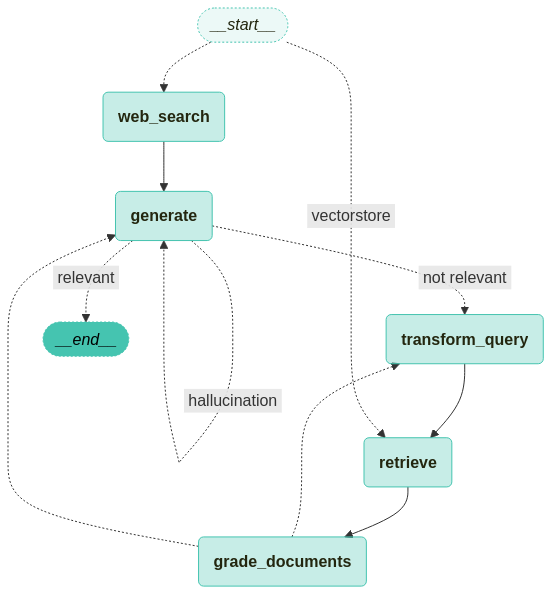

In [47]:
visualize_graph(app)

In [48]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import invoke_graph, stream_graph, random_uuid

In [49]:
config = RunnableConfig(                        # config 설정
    recursion_limit=20,                         # 최대 20개의 노드까지 방문.
    configurable={'thread_id': random_uuid()}   # thread_id 설정
)

inputs = GraphState(question='삼성전자가 개발한 생성형 AI 이름은?')

for event in app.stream(inputs, config=config):
    for node_name, node_chunk in event.items():
        print('[node_name]:', node_name)
        print('[node_chunk]:\n', node_chunk)


===== [ROUTE QUESTION] route_question() 함수 =====
==== [ROUTE QUESTION TO VECTORSTORE] ====


===== [RETRIEVE] retieve() 노드 실행 =====
문서 검색 결과: 
[Document(id='3cf9a215-1701-42d5-bab0-fcc18534266f', metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 12, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13462', 'Producer': 'Hancom PDF 1.3.0.542', 'CreationDate': "D:20231208132838+09'00'", 'ModDate': "D:20231208132838+09'00'", 'PDFVersion': '1.4'}, page_content='SPRi AI Brief |\n2023-12월호\n삼성전자, 자체 개발 생성 AI ‘삼성 가우스’ 공개\nKEY Contents\nn 삼성전자가 온디바이스에서 작동 가능하며 언어, 코드, 이미지의 3개 모델로 구성된 자체 개발 생성\nAI 모델 ‘삼성 가우스’를 공개\nn 삼성전자는 삼성 가우스를 다양한 제품에 단계적으로 탑재할 계획으로, 온디바이스 작동이 가능한\n삼성 가우스는 외부로 사용자 정보가 유출될 위험이 없다는 장점을 보유\n£언어, 코드, 이미지의 3개 모델로 구성된 삼성 가우스, 온디바이스 작동 지원'), Document(id='7caf4f89-ef25-4ffb-bc18-8426d0296be9', metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'pa

In [50]:
config = RunnableConfig(                        # config 설정
    recursion_limit=20,                         # 최대 20개의 노드까지 방문.
    configurable={'thread_id': random_uuid()}   # thread_id 설정
)

inputs = GraphState(question='대구 동성로')

for event in app.stream(inputs, config=config):
    for node_name, node_chunk in event.items():
        print('[node_name]:', node_name)
        print('[node_chunk]:\n', node_chunk)


===== [ROUTE QUESTION] route_question() 함수 =====
==== [ROUTE QUESTION TO WEB SEARCH] ====


===== [WEB SEARCH] web_search() 함수 =====
question: 
대구 동성로

web_results: 
[{'title': '대구 동성로 가볼만한곳 실내 놀거리 맛집 포함 : 네이버 블로그', 'url': 'https://m.blog.naver.com/kyui1/223576188105', 'content': '첫 번째 대구 동성로 가볼만한곳은. 바로 더 현대 대구지점이랍니다. 시기마다 다양한 팝업도 진행되고. 특히 먹거리 구경하는 재미가 있어요. 3만 원 이상 1시간, 5만 원 이상 2시간, 10만 원 이상 3시간 동안은 무료 주차가. 가능하다고 하니 이 부분 참고하세요.', 'score': 0.6461259, 'raw_content': '블로그\n\n카테고리 이동\n\n\n\n\n경상도 여행가 규이✈️\n\n대구 동성로 가볼만한곳 실내 놀거리 맛집 포함\n\n2024. 9. 8. 2:54\n\n대구에 거주하고 있는 분들이라면\n\n동성로 다들 한 번쯤은 들어보셨죠?\n\n\u200b\n\n오늘 실내  놀거리를 포함해 맛집,\n\n카페까지 다양한 정보 알려드릴게요.\n\n대구 동성로 가볼만한곳\n\n동성로 실내 놀거리 포함\n\n\u200b\n\n글, 사진: 규이\n\n\u200b\n\n1. 더 현대 대구\n\n주소: 대구 중구 달구벌 대로 2077\n\n운영시간: 10:30-20:00 / 백화점 휴무일 휴무\n\n첫 번째 대구 동성로 가볼만한곳은\n\n바로 더 현대 대구지점이랍니다.\n\n\u200b\n\n시기마다 다양한 팝업도 진행되고\n\n특히 먹거리 구경하는 재미가 있어요.\n\n\u200b\n\n3만 원 이상 1시간, 5만 원 이상 2시간,\n\n10만 원 이상 3시간 동안은 무료 주차가\n\n가능하다고 하니 이 부분 참고하세요.\n\n\u200b\n\n\u2